In [160]:
import numpy as np
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
sns.set_style("darkgrid")

In [14]:
# Load data in memory
train_data = pd.read_pickle("cern-data/4d_train.pkl")
test_data = pd.read_pickle("cern-data/4d_test.pkl")

In [148]:
# Utility function for plotting
def set_ticks(xticks, yticks):
    matplotlib.rc('xtick', labelsize=xticks)
    matplotlib.rc('ytick', labelsize=yticks)

In [174]:
# Mean Normalize the training data
train_data = (train_data - train_data.mean()) / train_data.std()
test_data = (test_data - test_data.mean()) / test_data.std()

In [175]:
# Give them better names
trainX = train_data
trainY = trainX
testX = test_data
testY = testX

In [178]:
# Visualize training data (Normalized)
train_data.sample(5)

,m,pt,phi,eta
78159,1.164414,1.145442,1.019927,-1.045889
9829,-0.550025,-0.380910,0.148613,-2.416429
36605,-0.596837,-0.599744,1.122043,0.850631
134133,-0.487780,-0.524523,1.561364,-0.638463
59984,-0.891937,-0.552911,-0.871909,-1.901096


In [173]:
class SAE(nn.Module):
    def __init__(self):
        """
        Stacked Auto encoder for Jet Data Compression
        This has 3 Latent Dimensions and uses Hyperbolic-tangent activation function.
        """
        super(SAE, self).__init__()
        self.en1 = nn.Linear(4, 20)
        self.en2 = nn.Linear(20, 10)
        self.en3 = nn.Linear(10, 5)
        self.en4 = nn.Linear(5, 3)
        self.de1 = nn.Linear(3, 5)
        self.de2 = nn.Linear(5, 10)
        self.de3 = nn.Linear(10, 20)
        self.de4 = nn.Linear(20, 4)
        self.activation = nn.Tanh()
    
    def encode(self, x):
        x = self.activation(self.en1(x))
        x = self.activation(self.en2(x))
        x = self.activation(self.en3(x))
        x = self.en4(x)
        return x
    
    def decode(self, x):
        x = self.activation(self.de1(x))
        x = self.activation(self.de2(x))
        x = self.activation(self.de3(x))
        x = self.de4(x)
        return x
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    
    def describe(self):
        return "in->20->10->5->3->5->10->20->out Stacked Autoencoder"

In [135]:
model = SAE()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.01, weight_decay=1e-6)
print(model)

SAE(
  (en1): Linear(in_features=4, out_features=20, bias=True)
  (en2): Linear(in_features=20, out_features=10, bias=True)
  (en3): Linear(in_features=10, out_features=5, bias=True)
  (en4): Linear(in_features=5, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=5, bias=True)
  (de2): Linear(in_features=5, out_features=10, bias=True)
  (de3): Linear(in_features=10, out_features=20, bias=True)
  (de4): Linear(in_features=20, out_features=4, bias=True)
  (activation): Tanh()
)


In [136]:
epochs = 350
lossess = []
for epoch in range(1, epochs+1):
    # Convert the training data into right shape: 
    # [Batch_size, Number of examples, Total Features]
    features = Variable(torch.FloatTensor(trainX.to_numpy())).unsqueeze(0)
    # Copy the features / as they will be the target
    target = features.clone()
    # Set last gradients to zero
    optimizer.zero_grad()
    # Make sure gradient of target is not calculated to save memory
    target.require_grad = False
    # Forward Pass
    prediction = model(features)
    # Calculate Loss
    lss = loss_fn(prediction, target)
    # Backward Pass
    lss.backward()
    # Optimize for one step
    optimizer.step()
    # Append the current loss to a list
    lossess.append(lss.data)
    # Print every 5 epochs
    if epoch%5==0 or epoch==1:
        print("Epoch: {}/{}, Loss: {}".format(epoch, epochs, str(lss.data)))

Epoch: 1/350, Loss: tensor(1.0026)
Epoch: 5/350, Loss: tensor(0.8966)
Epoch: 10/350, Loss: tensor(0.6395)
Epoch: 15/350, Loss: tensor(0.5953)
Epoch: 20/350, Loss: tensor(0.4375)
Epoch: 25/350, Loss: tensor(0.4218)
Epoch: 30/350, Loss: tensor(0.3765)
Epoch: 35/350, Loss: tensor(0.3765)
Epoch: 40/350, Loss: tensor(0.3588)
Epoch: 45/350, Loss: tensor(0.3435)
Epoch: 50/350, Loss: tensor(0.3343)
Epoch: 55/350, Loss: tensor(0.3272)
Epoch: 60/350, Loss: tensor(0.3191)
Epoch: 65/350, Loss: tensor(0.3120)
Epoch: 70/350, Loss: tensor(0.3063)
Epoch: 75/350, Loss: tensor(0.3022)
Epoch: 80/350, Loss: tensor(0.2983)
Epoch: 85/350, Loss: tensor(0.3009)
Epoch: 90/350, Loss: tensor(0.3004)
Epoch: 95/350, Loss: tensor(0.2955)
Epoch: 100/350, Loss: tensor(0.2904)
Epoch: 105/350, Loss: tensor(0.2904)
Epoch: 110/350, Loss: tensor(0.2885)
Epoch: 115/350, Loss: tensor(0.2875)
Epoch: 120/350, Loss: tensor(0.2869)
Epoch: 125/350, Loss: tensor(0.2856)
Epoch: 130/350, Loss: tensor(0.2907)
Epoch: 135/350, Loss: t

Text(0.5, 1.0, 'Reconstruction Loss')

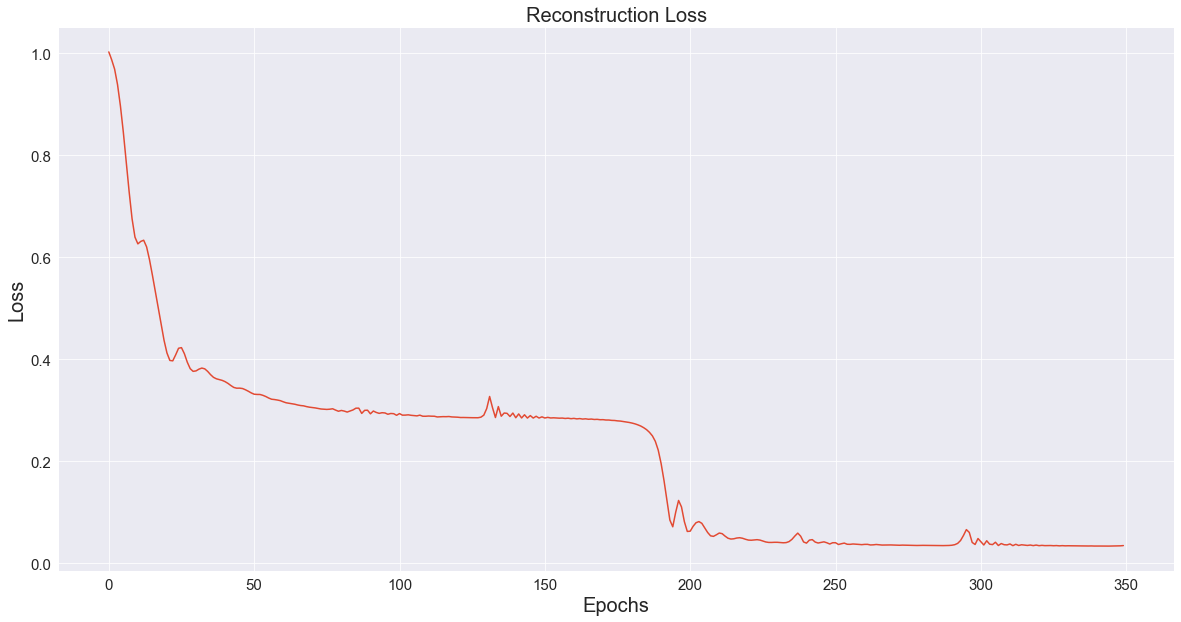

In [161]:
# Plot the reconstruction loss
plot_lossess = [x.item() for x in lossess]
set_ticks(15,15)
plt.figure(figsize=(20,10))
plt.plot(plot_lossess)
plt.xlabel("Epochs", size=20)
plt.ylabel("Loss", size=20)
plt.title("Reconstruction Loss", size=20)

In [162]:
###### Testing the model on Test Data (stored in testX)
# Compare the test output with test ground truth
test_val = Variable(torch.FloatTensor(np.array(testX)))
out = model(test_val)
ground_truth = testX

In [163]:
# Convert Torch Tensors to Numpy
ground_truth = ground_truth.to_numpy()
output = out.detach().numpy()

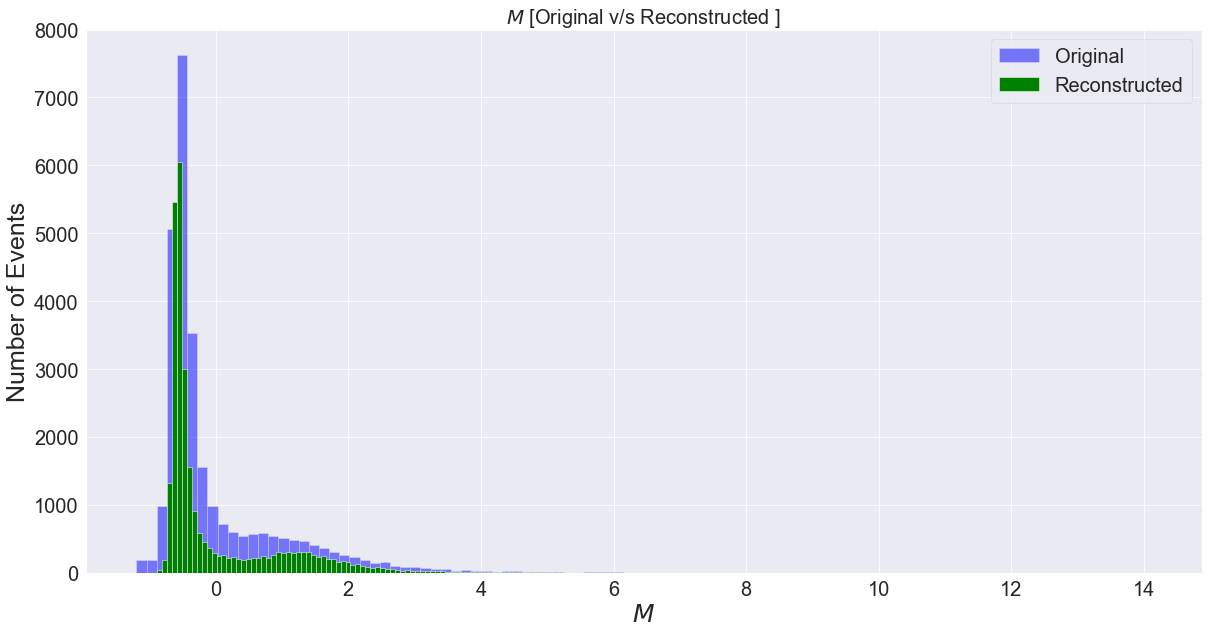

In [169]:
set_ticks(20,20)
plt.figure(figsize=(20,10))
plt.title(r'$M$ [Original v/s Reconstructed ]', size=20)
plt.xlabel(r'$M$', size=25)
plt.ylabel("Number of Events", size=25)
plt.hist(ground_truth_df[:,0], bins=100, color='blue', alpha=0.5)
plt.hist(output_df[:,0], bins=100, color='green')
plt.legend(["Original", "Reconstructed"], prop={'size': 20})

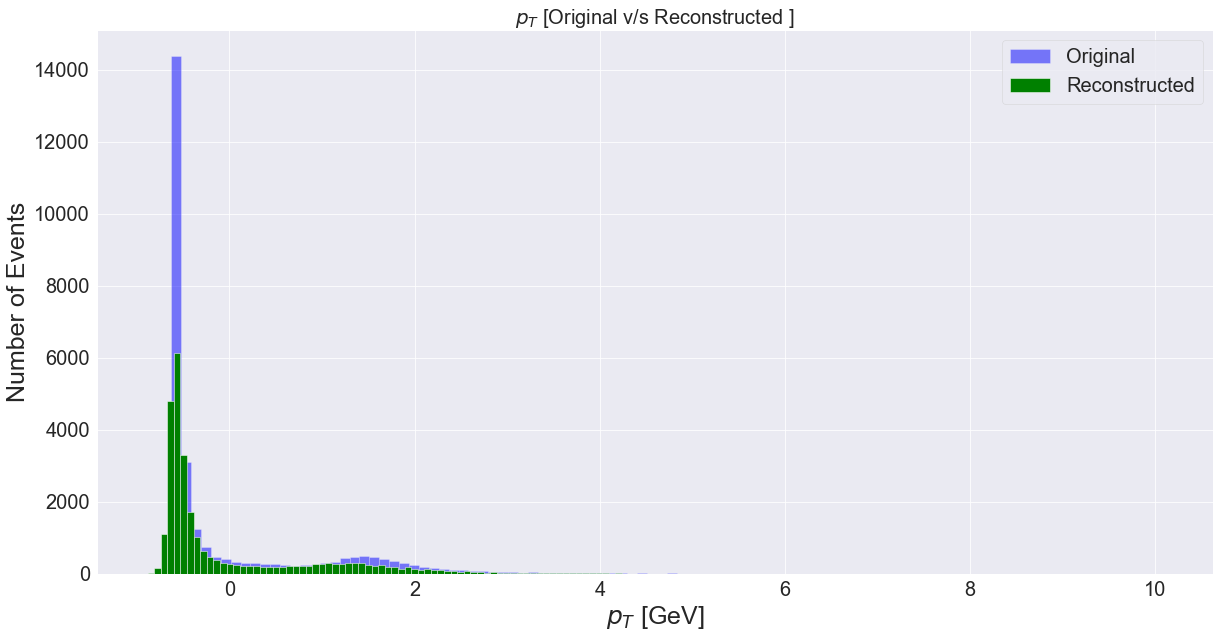

In [170]:
set_ticks(20,20)
plt.figure(figsize=(20,10))
plt.title(r'$p_T$ [Original v/s Reconstructed ]', size=20)
plt.xlabel(r'$p_T$ [GeV]', size=25)
plt.ylabel("Number of Events", size=25)
plt.hist(ground_truth_df[:,1], bins=100, color='blue', alpha=0.5)
plt.hist(output_df[:,1], bins=100, color='green')
plt.legend(["Original", "Reconstructed"], prop={'size': 20})

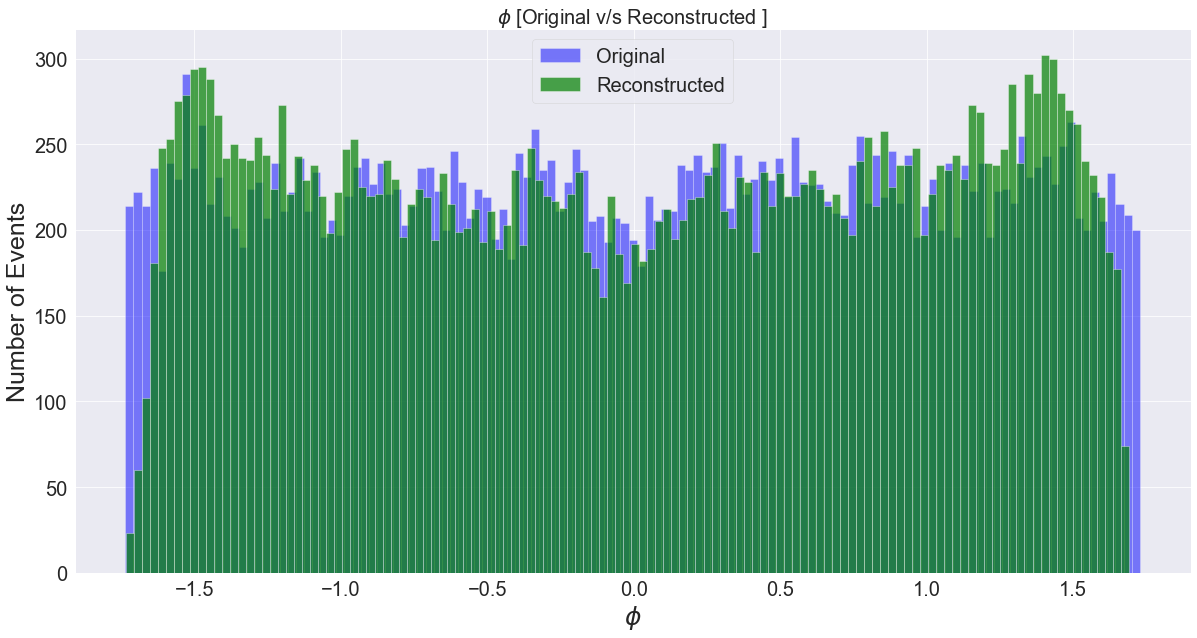

In [171]:
set_ticks(20,20)
plt.figure(figsize=(20,10))
plt.title(r'$\phi$ [Original v/s Reconstructed ]', size=20)
plt.xlabel(r'$\phi$', size=25)
plt.ylabel("Number of Events", size=25)
plt.hist(ground_truth_df[:,2], bins=125, color='blue',alpha=0.5)
plt.hist(output_df[:,2], bins=125, color='green',alpha=0.7)
plt.legend(["Original", "Reconstructed"], prop={'size': 20})

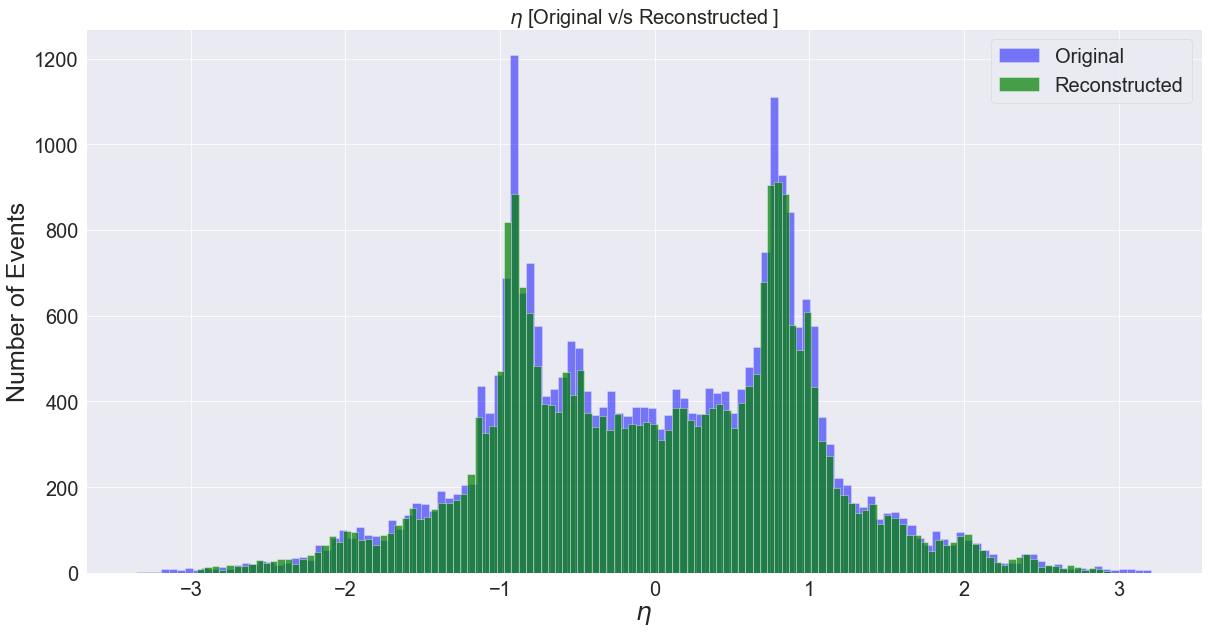

In [172]:
set_ticks(20,20)
plt.figure(figsize=(20,10))
plt.title(r'$\eta$ [Original v/s Reconstructed ]', size=20)
plt.xlabel(r'$\eta$', size=25)
plt.ylabel("Number of Events", size=25)
plt.hist(ground_truth_df[:,3], bins=125, color='blue',alpha=0.5)
plt.hist(output_df[:,3], bins=125, color='green',alpha=0.7)
plt.legend(["Original", "Reconstructed"], prop={'size': 20})